In [1]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import Categorical

from utils.minipacman import MiniPacman
from utils.multiprocessing_env import SubprocVecEnv

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class ActorCritic(nn.Module):  
    def __init__(self, in_shape, n_actions):
        super(ActorCritic, self).__init__()
        
        self.in_shape = in_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(in_shape[0], 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
        )
        
        self.critic_network = nn.Linear(256, 1)
        self.actor_network = nn.Linear(256, n_actions)
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logit = self.actor_network(x)
        value = self.critic_network(x)
        return logit, value
    
        
    def act(self, x, deterministic=False):
        logit, _ = self.forward(x)
        probs = F.softmax(logit, dim=-1)
        
        if deterministic:
            action = probs.max(1)[1]
        else:
            action = probs.multinomial(1)
        
        return action
    
    def evaluate_actions(self, x, action):
        logit, value = self.forward(x)
        
        probs     = F.softmax(logit, dim=-1)
        log_probs = F.log_softmax(logit, dim=-1)
        
        action_log_probs = log_probs.gather(1, action)
        entropy = -(probs * log_probs).sum(1).mean()
        
        return logit, action_log_probs, value, entropy
        
    def feature_size(self):
        return self.features(torch.zeros(1, *self.in_shape)).view(1, -1).size(1)

In [3]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_envs, state_shape):
        self.num_steps = num_steps
        self.num_envs = num_envs
        self.states = torch.zeros(num_steps+1, num_envs, *state_shape)
        self.rewards = torch.zeros(num_steps, num_envs, 1)
        self.masks = torch.ones(num_steps+1, num_envs, 1)
        self.actions = torch.zeros(num_steps, num_envs, 1).long()
            
    def to(self, device):
        self.device = device
        self.states = self.states.to(device)
        self.rewards = self.rewards.to(device)
        self.masks = self.masks.to(device)
        self.actions = self.actions.to(device)
        
    def insert(self, step, state, action, reward, mask):
        self.states[step+1].copy_(state)
        self.actions[step].copy_(action)
        self.rewards[step].copy_(reward)
        self.masks[step+1].copy_(mask)
        
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])
        
    def compute_returns(self, next_value, gamma):
        returns = torch.zeros(self.num_steps + 1, self.num_envs, 1).to(self.device)
        returns[-1] = next_value
        for step in reversed(range(self.num_steps)):
            returns[step] = returns[step+1] * gamma * self.masks[step + 1] + self.rewards[step]
        return returns[:-1]

In [4]:
mode = "regular"
num_envs = 16

def make_env():
    def _thunk():
        env = MiniPacman(mode, 1000)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape

In [5]:
#a2c hyperparams:
gamma = 0.99
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
num_steps = 10
num_frames = int(1e5)

#rmsprop hyperparams:
lr    = 7e-4
eps   = 1e-5
alpha = 0.99

#Init a2c and rmsprop
actor_critic = ActorCritic(envs.observation_space.shape, envs.action_space.n)
actor_critic.to(DEVICE)
optimizer = optim.RMSprop(actor_critic.parameters(), lr, eps=eps, alpha=alpha)

In [6]:
rollout = RolloutStorage(num_steps, num_envs, envs.observation_space.shape)
rollout.to(DEVICE)

all_rewards = []
all_losses  = []

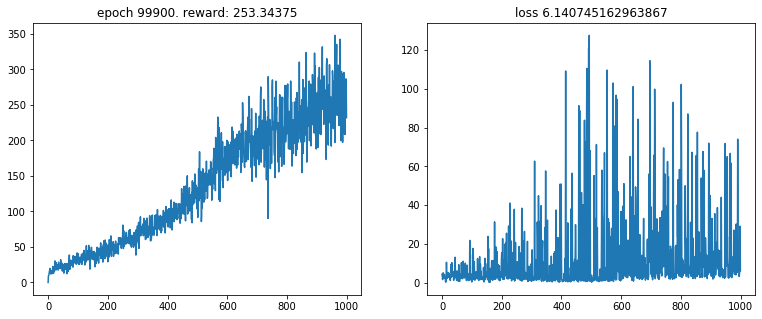

In [7]:
state = envs.reset()
state = torch.FloatTensor(np.float32(state)).to(DEVICE)

    
rollout.states[0].copy_(state)

episode_rewards = torch.zeros(num_envs, 1)
final_rewards   = torch.zeros(num_envs, 1)

for i_update in range(num_frames):

    for step in range(num_steps):
        action = actor_critic.act(state)

        next_state, reward, done, _ = envs.step(action.squeeze(1).cpu().data.numpy())

        reward = torch.FloatTensor(reward).unsqueeze(1)
        episode_rewards += reward
        masks = torch.FloatTensor(1-np.array(done)).unsqueeze(1)
        final_rewards *= masks
        final_rewards += (1-masks) * episode_rewards
        episode_rewards *= masks

        masks.to(DEVICE)

        state = torch.FloatTensor(np.float32(next_state)).to(DEVICE)
        rollout.insert(step, state, action.data, reward, masks)


    with torch.no_grad():
        _, next_value = actor_critic(rollout.states[-1])
        
    next_value = next_value.data

    returns = rollout.compute_returns(next_value, gamma)

    logit, action_log_probs, values, entropy = actor_critic.evaluate_actions(
        rollout.states[:-1].detach().view(-1, *state_shape),
        rollout.actions.detach().view(-1, 1)
    )

    values = values.view(num_steps, num_envs, 1)
    action_log_probs = action_log_probs.view(num_steps, num_envs, 1)
    advantages = returns.detach() - values

    value_loss = advantages.pow(2).mean()
    action_loss = -(advantages.detach() * action_log_probs).mean()

    optimizer.zero_grad()
    loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
    loss.backward()
    nn.utils.clip_grad_norm_(actor_critic.parameters(), max_grad_norm)
    optimizer.step()
    
    if i_update % 100 == 0:
        all_rewards.append(final_rewards.mean())
        all_losses.append(loss.data)
        
        display.clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title(f"epoch {i_update}. reward: {np.mean(all_rewards[-10:])}")
        plt.plot(all_rewards)
        plt.subplot(132)
        plt.title(f"loss {all_losses[-1].item()}")
        plt.plot(all_losses)
        plt.show()
        
    rollout.after_update()

In [8]:
torch.save(actor_critic.state_dict(), "actor_critic")

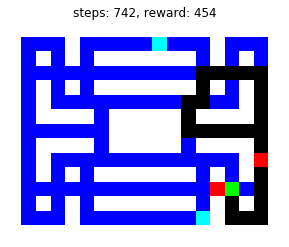

In [10]:
env = MiniPacman(mode, 1000)
state = env.reset()
done = False
total_reward = 0
step = 1

while not done:
    current_state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
    action = actor_critic.act(current_state)
    next_state, reward, done, _ = env.step(action.data[0, 0])
    total_reward += reward
    state = next_state
    
    plt.imshow(state.transpose([1, 2, 0]))
    plt.axis('off')
    plt.title(f"steps: {step}, reward: {total_reward}")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.2)
    
    step += 1